# Importing the dataset

In [6]:
from __future__ import unicode_literals
import hazm
import numpy as np
# import tensorflow as tf
import pandas as pd
from collections import Counter
import csv, re, pickle

# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Flatten
# import numpy as np
# from keras.utils import to_categorical
# import re
# from utils import words_list, stopwords_list
# from stopping_utility import *
# import nltk
# import wapiti

from colorama import Back, Fore, Style
import time

import matplotlib.pyplot as plt


from os import path
from persian_wordcloud.wordcloud import PersianWordCloud, add_stop_words
from wordcloud import STOPWORDS as EN_STOPWORDS
from wordcloud_fa import WordCloudFa


import seaborn as sns
sns.set()

# from sklearn import metrics
# import sklearn.metrics as sm
# from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import Birch
# from sklearn import manifold
# import pyclustering as pyclus

In [7]:
data = pd.read_csv('news_202010261937.csv')
data.head()

,id,created_at,updated_at,deleted_at,code,title,lead,body,genre
0,168298,2020-10-24 13:09:52,2020-10-24 13:09:52,NaN,13980429001132,فیلم| عملیات توقیف نفتکش انگلیسی توسط تکاوران ...,فیلم عملیات توقیف نفتکش انگلیسی «Stena Impero»...,به گزارش خبرنگار دفاعی خبرگزاری فارس، فیلم عمل...,politics
1,168314,2020-10-24 13:10:01,2020-10-24 13:10:01,NaN,13980429001116,جزئیات جدیدی از توقیف نفتکش انگلیسی/ در اعمال ...,سخنگوی سپاه با اشاره به نقض قانون توسط نفتکش ا...,به گزارش گروه دفاعی خبرگزاری فارس، سردار رمضان...,politics
2,168316,2020-10-24 13:10:01,2020-10-24 13:10:01,NaN,13980429000996,چهار کشتی ایرانی در انتظار سوخت در بنادر برزیل...,رویترز طی گزارشی نوشت دو کشتی دیگر ایران نیز د...,به گزارش گروه اقتصاد بین‌الملل فارس به نقل از ...,economy
3,168318,2020-10-24 13:10:03,2020-10-24 13:10:03,NaN,13980429001007,نگرانی تجار برزیلی از خراب شدن تجارت با ایران/...,درحالی‌که رئیس‌جمهور برزیل تلاش می‌کند با جلب ...,به گزارش گروه اقتصاد بین‌الملل فارس به نقل از ...,economy
4,168320,2020-10-24 13:10:04,2020-10-24 13:10:04,NaN,13980429001096,جدال با هویت دینی جامعه ایرانی؛ توصیه استعمارک...,شاخص‌ترین هویت زن ایرانی حتی از قرن‌های پیش از...,به گزارش گروه سیاسی خبرگزاری فارس، علی قربان‌ن...,politics


In [8]:
news = list(data[data['genre']=='economy']['body'])

# news

In [9]:
# i = 0
# for rev in news:
#     if type(rev) == float:
#         print(rev,i)
#     i += 1
# news[658]

In [10]:
news = pd.DataFrame(news)
news.rename(columns={0:'body'} , inplace=True)
news.head()

,body
0,به گزارش گروه اقتصاد بین‌الملل فارس به نقل از ...
1,به گزارش گروه اقتصاد بین‌الملل فارس به نقل از ...
2,به گزارش خبرگزاری فارس به نقل از روابط عمومی و...
3,به گزارش خبرگزاری فارس، شبکه تحلیلگران اقتصاد ...
4,به گزارش خبرنگار اقتصادی خبرگزاری فارس، بر اسا...


# Preliminary text exploration

## Fetch word count for each abstract

In [12]:
#Fetch wordcount for each abstract
news['word_count'] = news['body'].apply(lambda x: len(str(x).split(" ")))
news[['body','word_count']].head()


,body,word_count
0,به گزارش گروه اقتصاد بین‌الملل فارس به نقل از ...,425
1,به گزارش گروه اقتصاد بین‌الملل فارس به نقل از ...,364
2,به گزارش خبرگزاری فارس به نقل از روابط عمومی و...,147
3,به گزارش خبرگزاری فارس، شبکه تحلیلگران اقتصاد ...,724
4,به گزارش خبرنگار اقتصادی خبرگزاری فارس، بر اسا...,601


In [ ]:
news['body']

In [13]:
##Descriptive statistics of word counts
news.word_count.describe()

count    15694.000000
mean       510.806168
std        558.083765
min         33.000000
25%        214.250000
50%        349.000000
75%        619.000000
max      27379.000000
Name: word_count, dtype: float64

In [8]:
sum(news['body'].isna())

0

## cleaning data from none texts, digits, and ...

In [12]:


RE_USELESS = r'[^\w]'  # remove useless characters
RE_DIGIT = r"^\d+\s|\s\d+\s|\s\d+$"  # remove digits
RE_SPACE = r'\s+'  # remove space
RE_EMAILS = r'[\w\.-]+@[\w\.-]+'
RE_URLS = r'http\S+'
RE_WWW = r'www\S+'


def clean_all_save(document, save_file_path):
    """
    this function generate raw persian text, it remove non-persian character
    and all numbers and symbols
    :param document:
    :param save_file_path:
    :return:
    """
    with open(save_file_path, 'w') as output:
        for sentence in document:
            sentence = clean_sentence(sentence)
            output.write(sentence + '\n')
    return None


def clean_all(document, doc_pattern=r'<TEXT>(.*?)</TEXT>'):
    """
    clean text like hamshahri, irBlogs, and other Treck format
    :param document:
    :param doc_pattern:
    :return:
    """
    clean = ''
    document = re.findall(doc_pattern, document, re.DOTALL)
    for sentence in document:
        sentence = clean_sentence(sentence)
        clean += ' \n' + sentence
    return clean


def clean_sentence(sentence):
    sentence = re.sub(r'[^\u0621-\u06ff]', ' ', sentence)
    sentence = arToPersianChar(sentence)
    sentence = arToPersianNumb(sentence)
    sentence = faToEnglishNumb(sentence)
    sentence = re.sub(r'[0-9]', ' ', sentence)
    sentence = re.sub(RE_WWW, r' ', sentence)
    sentence = re.sub(RE_URLS, r' ', sentence)
    sentence = re.sub(RE_EMAILS, r' ', sentence)
    sentence = re.sub(RE_USELESS, r' ', sentence)
    sentence = re.sub(RE_DIGIT, r' ', sentence)
    sentence = re.sub(RE_SPACE, r' ', sentence)
    sentence = re.sub(r'[a-zA-Z]', ' ', sentence)
    return sentence


def arToPersianNumb(number):
    dic = {
        '١': '۱',
        '٢': '۲',
        '٣': '۳',
        '٤': '۴',
        '٥': '۵',
        '٦': '۶',
        '٧': '۷',
        '٨': '۸',
        '٩': '۹',
        '٠': '۰',
    }
    return multiple_replace(dic, number)


def arToPersianChar(userInput):
    dic = {
        'ك': 'ک',
        'دِ': 'د',
        'بِ': 'ب',
        'زِ': 'ز',
        'ذِ': 'ذ',
        'شِ': 'ش',
        'سِ': 'س',
        'ى': 'ی',
        'ي': 'ی'
    }
    return multiple_replace(dic, userInput)


def faToEnglishNumb(number):
    dic = {
        '۰': '0',
        '۱': '1',
        '۲': '2',
        '۳': '3',
        '۴': '4',
        '۵': '5',
        '۶': '6',
        '۷': '7',
        '۸': '8',
        '۹': '9',
    }
    return multiple_replace(dic, number)


def multiple_replace(dic, text):
    pattern = "|".join(map(re.escape, dic.keys()))
    return re.sub(pattern, lambda m: dic[m.group()], str(text))

In [13]:
def clean_all(document):
    clean = ''
    for sentence in document:
        sentence = clean_sentence(sentence)
        clean += sentence
    return clean

In [26]:
stopwords = list(pd.read_csv('STOPWORDS.csv',header=None)[0])
# stopwords

In [31]:
    
j = k = i = 0
news1 = []
# labels1 = []
# labels1 = list(labels.copy())
normalizer = hazm.Normalizer()
for review in news['body']:
    sentences = normalizer.normalize(clean_all(review))
    ##Convert to list from string
    text = hazm.word_tokenize(sentences)
    ##Stemming
#     ps=PorterStemmer()
    #Lemmatisation
    lem = hazm.Lemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stopwords] 
    text = " ".join(text)
 
    news1.append(text)
    
#     for j in range(len(sentences)):
#         labels1.insert(i + k, labels[i])
#         k += 1
    i += 1

In [33]:
print(len(news1))

15694


In [34]:
news1[0]

'گزارش گروه اقتصاد الملل فارس نقل رویترز کشتی فله ایران محموله اوره برزیل قرار محموله ذرت ایران برگردند سوخت ماند#مان زیرا شرکت دولت پتروبراس فروش سوخت بانکر علت تحریم آمریکا خوددار کرد#کن آمار رهیاب کشتی داد#ده کشتی مدل پاناماگذر کشتی عبور کانال پاناما دلربا گنج نزدیک بندر ایمبیتوبا جنوب برزیل لنگر انداخت#انداز قرار مسیر مشابه کشتی باوند ترمه مشکل سوخت کشتی مالکیت دولت ایران قرار تحریم قرار تامین اصل سوخت بانکر برزیل شرکت ترنس پترو شعبه پتروبراس شرکت فروش سوخت پتروبراس تنبیه آمریکا فعالیت هایش کشور مواجه کشتی کشتی پنجم دریابار موفق ترک برزیل محموله ذرت مسیر تجار دولت ایران دنبال بازار محصولات پتروشیمی جبران فروش نفت منبع صنعتی کشتیرانی دولت ایران ریسک کرد#کن تمام کشتی دانست#دان قادر سوخت مجدد بازگشت فرستاد#فرست علی رغم بیانیه پتروبراس کرد#کن شرکت توانست#توان کشتی سوخت فروخت#فروش منبع صنعتی انحصار سوختگیری مجدد بنادر برزیل اختیار شرکت دولت کشتی دریابار اوره برزیل آورد#آور مشخص سوخت بازگشت تهیه کرد#کن اساس آمار رهیاب کشتی کشتی نزدیک آفریقا جنوبی پتروبراس موضع تایید شرکت ریسک قرارداد بست

## saving news to file

In [35]:

# data['body'][data['genre']=='economy'] = news1
# data.to_excel("PreprocessedNews_economy.xlsx", index=False)

In [2]:
economydata = data[data['genre']=='economy']
economydata['body'] = news1
economydata.to_excel("Preprocessed_via_HAZM_News_economy.xlsx", index=False)

del data

NameError: name 'data' is not defined

In [52]:
# economydata.to_excel("PreprocessedNews_economy.xlsx", index=False)


### Preprocess finished

In [14]:
economydata = pd.read_excel("Preprocessed_via_HAZM_News_economy.xlsx")
reviews1 = list(economydata['body'])

print(len(reviews1))
economydata.head()


15694


,id,created_at,updated_at,deleted_at,code,title,lead,body,genre
0,168316,2020-10-24 13:10:01,2020-10-24 13:10:01,NaN,13980429000996,چهار کشتی ایرانی در انتظار سوخت در بنادر برزیل...,رویترز طی گزارشی نوشت دو کشتی دیگر ایران نیز د...,گزارش گروه اقتصاد الملل فارس نقل رویترز کشتی ف...,economy
1,168318,2020-10-24 13:10:03,2020-10-24 13:10:03,NaN,13980429001007,نگرانی تجار برزیلی از خراب شدن تجارت با ایران/...,درحالی‌که رئیس‌جمهور برزیل تلاش می‌کند با جلب ...,گزارش گروه اقتصاد الملل فارس نقل رویترز ژائیر ...,economy
2,168335,2020-10-24 13:10:13,2020-10-24 13:10:13,NaN,13980429001089,بیات عضو هیئت مدیره شرکت ملی صنایع پتروشیمی شد,وزیر نفت در حکمی، عبدالحسین بیات را به مدت سه ...,گزارش خبرگزاری فارس نقل روابط عموم وزارت نفت و...,economy
3,168366,2020-10-24 13:10:30,2020-10-24 13:10:30,NaN,13980429001047,ضرورت راه اندازی پیام‌رسان مالی جایگزین سوئیفت...,در بخشی از گزارش شبکه تحلیلگران اقتصاد مقاومتی...,گزارش خبرگزاری فارس شبکه تحلیلگر اقتصاد مقاومت...,economy
4,170673,2020-10-24 13:29:26,2020-10-24 13:29:26,NaN,13980431000516,افزایش 3386 واحدی شاخص بورس تهران,شاخص کل بورس اوراق بهادار تهران در پایان معامل...,گزارش خبرنگار اقتصاد خبرگزاری فارس اساس اطلاعا...,economy


In [15]:
type(reviews1)

list

## Most common and uncommon words

In [16]:
#Identify common words
freq = pd.Series(' '.join(reviews1).split()).value_counts()
f = list(pd.DataFrame(freq).index)
# f

In [17]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(reviews1).split()).value_counts()[-20:]
freq1

حدوث           1
نرمه           1
بنگاهدار       1
برابرشده       1
خانوارعشایر    1
النعیمی        1
ماتوسکه        1
تعاقب          1
مینوز          1
هنجارسازی      1
االعبور        1
درراه          1
رهانیدن        1
زیرتصویب       1
اورانه         1
رفرم           1
فولادیزد       1
معصومان        1
دینه           1
بالز           1
dtype: int64

## Deleting stop words

In [18]:
stop_words = pd.read_csv('STOPWORDS.csv',header=None)
len(set(list(stop_words[0])))

781

In [19]:
# list(stop_words[0])

In [20]:
#Word cloud for English and Persian

#!/usr/bin/env python
"""
Minimal Example
===============
Generating a square wordcloud from the US constitution using default arguments.
"""
# Add another stopword

# stopwords = add_stop_words(f[0:250])
stopwords = add_stop_words(['میشه'])
stopwords |= EN_STOPWORDS
print(len(stopwords))
stopwords |= set(list(stop_words[0]))
stopwords |= set(['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll',
                  'mustn', 're',
                  'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn',
                  'اثر', 'البت', 'بالای', 'تول'
                  , 'توی', 'تی', 'جلوی', 'حدود', 'خارج', 'دنبال', 'رسد', 'رود', 'سری','میشه', 'جواب بدین',
                  'جواب بدید', 'میگه', 'اون','بدید', 'بدین', 'جواب','سلام',
                  'سمت', 'ضد', 'طبق', 'عقب'
                  , 'عل', 'قصد', 'مد', 'نزد', 'نزدیک', 'وسط', 'پاعین', 'ﺮﺗ', 'ﺱﺎﺳﺍﺮﺑ', 'ﺶﺷ', 'ﻪﺘﺷﺍﺪﻧ'])
len(stopwords)

669


1418

In [21]:
# stopwords = add_stop_words(['میشه'])
# stopwords

In [22]:
stopwords1 = stopwords.copy()
for st in stopwords1:
    if type(st)==int or type(st)==float or type(st)==type(True):
        stopwords.remove(st)
        print(st)
del stopwords1
len(stopwords)
stopwords = list(stopwords)

In [23]:
# print(stopwords)

In [24]:
# # Python program for insert and search 
# # operation in a Trie 

# class TrieNode: 

#     # Trie node class 
#     def __init__(self): 
#         self.children = [None]*80000

#         # isEndOfWord is True if node represent the end of the word 
#         self.isEndOfWord = False

# class Trie: 

#     # Trie data structure class 
#     def __init__(self): 
#         self.root = self.getNode() 

#     def getNode(self): 

#         # Returns new trie node (initialized to NULLs) 
#         return TrieNode() 

#     def _charToIndex(self,ch): 

#         # private helper function 
#         # Converts key current character into index 
#         # use only 'a' through 'z' and lower case 

#         return ord(ch)-ord('!') 


#     def insert(self,key): 

#         # If not present, inserts key into trie 
#         # If the key is prefix of trie node, 
#         # just marks leaf node 
#         pCrawl = self.root 
#         length = len(key) 
#         for level in range(length): 
#             index = self._charToIndex(key[level]) 

#             # if current character is not present 
#             if not pCrawl.children[index]: 
#                 pCrawl.children[index] = self.getNode() 
#             pCrawl = pCrawl.children[index] 

#         # mark last node as leaf 
#         pCrawl.isEndOfWord = True

#     def search(self, key): 

#         # Search key in the trie 
#         # Returns true if key presents 
#         # in trie, else false 
#         pCrawl = self.root 
#         length = len(key) 
#         for level in range(length): 
#             index = self._charToIndex(key[level]) 
#             if not pCrawl.children[index]: 
#                 return False
#             pCrawl = pCrawl.children[index] 

#         return pCrawl != None and pCrawl.isEndOfWord 




In [25]:
# i = 0
# keys = list(stopwords)

# # Trie object 
# t = Trie() 

# # Construct trie 
# for key in keys: 
#     t.insert(key) 

# # reviews = reviews1.copy()
# # for rev in reviews1:
# # #     rev = rev.replace('\u200c',' ')
# # #         rev = rev.replace('\u200f',' ')
# # #         rev = re.sub(r'[^a-zA-Z0-9آ-ی۰-۹ ]', ' ', rev)
# #     words = rev.split(' ')

# #     words1 = words.copy()
# #     for w in words:
# #         if w == '':
# #             words1.remove(w)
# #             continue
# #         if t.search(w):
# #             words1.remove(w)

# #     words = words1
# #     text = ''
# #     for w in words:
# #         text += w + ' '
# #     reviews[i] = text
# #     i += 1

# # reviews1 = reviews.copy()
# # del reviews

In [26]:
# ord('!')-ord('!')

In [27]:
# # Input keys (use only 'a' through 'z' and lower case) 
# keys = list(stopwords.loc[:,0])

# output = ["Not present in trie", 
#         "Present in trie"] 

# # Trie object 
# t = Trie() 

# # Construct trie 
# for key in keys: 
#     t.insert(key) 


# print("{} ---- {}".format("از",output[t.search("از")])) 



In [28]:
# ### stopword deletion Testing
# rev = reviews1[0]

# print(rev)
# #rev = rev.replace('\u200c',' ')
# rev = rev.replace('\u200f',' ')
# rev = re.sub(r'[^a-zA-Z0-9آ-ی۰-۹ ]', ' ', rev)
# rev.split(' ')
# words = rev.split()

# words1 = words.copy()
# for w in words:
#     if w == '':
#         words1.remove(w)
#         continue
#     if t.search(w):
#         words1.remove(w)

# words = words1
# text = ''
# for w in words:
#     text += w + ' '
# text


In [29]:
# keys

In [30]:
# i = 0
# for rev in reviews1:
#     if type(rev) == float:
#         print(rev,i)
#     i += 1

### Stop word deleting finished

In [31]:
## If you wish to withdraw stopword deletion, uncomment the below line, and run it.
# reviews = reviews1

In [32]:
# #cleaning dataset
# #word_tokenize
# words=[]
# all_text = ''
# # stemmer = Stemmer()
# for i in range (len(reviews)):
#     text = reviews[i]
# #     text = text.replace('\u200c',' ')
#     text = text.replace('\u200f',' ')
#     text = re.sub(r'[^a-zA-Z0-9آ-ی۰-۹ ]', ' ', text)
#     all_text += text
#     all_text += ' '
#     wordsInText = text.split()
#     for word in wordsInText:
#         if word != ' ' or word != '':
#             words.append(word)
# len(words)

In [33]:
reviews1[1]

'گزارش گروه اقتصاد الملل فارس نقل رویترز ژائیر بولسونارو رئیس جمهور برزیل دولت برزیل شرکت داخل تحریم اعمال آمریکا ایران پیامد احتمال تبعیت هشدار داد#ده اظهارات رویترز گزارش کشتی ایران سواحل برزیل گیر کرد#کن علت نداشتن سوخت قادر بازگشت #هست ایراد پتروپراس شرکت دولت بازار محل سوخت بانکر اختیار فروش سوخت کشتی خوددار کرد#کن ژائیر بولسونارو رئیس جمهور برزیل بولسونارو خبرنگار مشکل آمریکا تحریم جانبه ایران اعمال کرد#کن شرکت برزیل وضعیت اطلاع داد#ده افزود#افزا تلاش کرد#کن روابط نزدیک آمریکا برقرار نفع برزیل رئیس جمهور برزیل ادامه ترامپ نزدیک شد#شو دیدار آمریکا اقتصاد شماره جهان دومین بازار برزیل دست هایش معامله همکار کرد#کن تجار برزیل بیم وضعیت کشتی ایران ذرت بارگیری توانست#توان حرکت تجارت ایران تاثیر گذاشت#گذار ایران بزرگ واردکنندگان غلات برزیل بولسونارو برزیل کشور اختلاف جنگ درگیری خواست#خواه وضعیت حفظ فهمید#فهم کشور مشکل فکر منافع رویترز گزارش نوشت#نویس کشتی ایران هفته هاست بنادر برزیل لنگر انداخت#انداز علت نداشتن سوخت قادر #هست ایران بازگردند زیرا شرکت دولت نفت گاز پتروبراس برزیل فروش سوخت

In [34]:
i = 0
nulltextindex = []
holdingCorpus = reviews1.copy()
corpus1 = reviews1.copy()
for rev in corpus1:
#     rev = rev.replace('\u200c',' ')
    rev = rev.replace('\u200f',' ')
    rev = re.sub(r'[^a-zA-Zآ-ی]', ' ', rev)
    rev.split(' ')
    words = rev.split(' ')

    words1 = words.copy()
    for w in words:
        if w == ''or type(w)==int or type(w)==float or type(w)==bool:
            words1.remove(w)
            continue
        if w in stopwords:
            words1.remove(w)

    words = words1.copy()
    text = ''
    for w in words:
        text += w + ' '
    corpus1[i] = text
    if type(text)!= str or len(text)==0 :
        nulltextindex.append(i)
    i += 1
corpus = corpus1.copy()
del corpus1
nulltextindex

[]

In [35]:
text = ''
for tex in corpus:
    text = text+ ' \n' +tex

In [36]:
# text[:111]

In [37]:
# for cp in corpus:    
#     for w in cp.split():
#         if w in stopwords:
#             print(w)

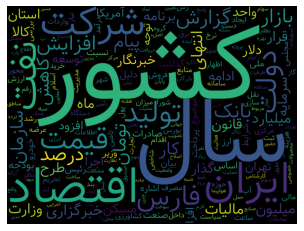

In [38]:
wodcloud = WordCloudFa(no_reshape=False, persian_normalize=True, include_numbers=False,
                       collocations=False, width=1200, height=900)

wc = wodcloud.generate(text)
image = wc.to_image()
image.show()
image.save('wordcloud.png')

print(wc)
fig = plt.figure(1)

plt.imshow(wc)
plt.axis('off')
plt.show()

In [39]:
# # Generate a word cloud image

# wordcloud = PersianWordCloud(
#     only_persian=True,
#     max_words=200,
#     stopwords=stopwords,
#     margin=0,
#     width=1200,
#     height=900,
#     min_font_size=1,
#     max_font_size=500,
#     background_color="black"
# ).generate(text)

# image = wordcloud.to_image()
# image.show()
# image.save('en-fa-result.png')

# print(wordcloud)
# fig = plt.figure(1)

# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stopwords, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [41]:
list(cv.vocabulary_.keys())[:10]

['گروه',
 'الملل',
 'نقل',
 'رویترز',
 'کشتی',
 'فله',
 'ایران',
 'محموله',
 'اوره',
 'برزیل']

In [42]:
#Most frequently occuring words
from matplotlib import font_manager as fm, rcParams
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)
#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30, ,direction = 'rtl',name = 'Yas')

SyntaxError: invalid syntax (<ipython-input-42-0754ce1653de>, line 20)

In [ ]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45, name = 'XB Niloofar')

In [ ]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()


In [ ]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=20):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [ ]:
dockeys = []
i = j = 0
droppList = []
for doc in corpus:
#     # fetch document for which keywords needs to be extracted
#     doc=corpus[500]
    if len(doc.split())<5:
        doc = holdingCorpus[i]
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    #extract only the top n; n here is 100

    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
#     print(doc)
#     print(feature_names[:20])
#     print(sorted_items[:20])
#     break
    # now print the results
#     print("\nQuestion:")
#     print(doc)
#     print("\nKeywords:")
    Qkey = ''
    keyScore = []
    for k in keywords:

        Qkey = Qkey + ' '+k
    
    if len(Qkey)<3:
        droppList.append(i)
        j += 1
        #print(j, dataset['text'][i])
        i += 1
        continue
    dockeys.append(Qkey)
    i += 1


In [ ]:
len(economydata)

In [ ]:
economydata.drop(droppList,inplace=True)
economydata['News_keyword'] = dockeys

In [ ]:
economydata.to_excel('economydata_kewords and key score.xlsx', index=False)
economydata = pd.read_excel('economydata_kewords and key score.xlsx')

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# iris = sns.load_dataset("iris")
# g = sns.PairGrid(iris)
# g = g.map(plt.scatter)

## Embedding

In [2]:
# # Bulding the dictionary
# counts = Counter(words)
# vocab = sorted(counts, key=counts.get, reverse=True)
# vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

# with open("mySavedDict.txt", "wb") as myFile:
#     pickle.dump(vocab_to_int, myFile)

# '''
# with open("mySavedDict.txt", "rb") as myFile:
#     myNewPulledInDictionary = pickle.load(myFile)
# '''

In [18]:
# vocab

In [3]:
# reviews_ints = []
# for each in reviews:
#     #print (each)
# #     each = each.replace('\u200c',' ')
#     each = each.replace('\u200f',' ')
#     each = re.sub(r'[^a-zA-Z0-9آ-ی۰-۹ ]', ' ', each)
#     reviews_ints.append([vocab_to_int[word] for word in each.split()])


# review_lens = Counter([len(x) for x in reviews_ints])
# print("Zero-length reviews: {}".format(review_lens[0]))
# print("Maximum review length: {}".format(max(review_lens)))


In [4]:
# mi = 15000
# su = ma = 0
# i = 0
# low = []
# for each in reviews_ints:
#     if len(each) == 2 or len(each) == 1 or len(each) == 0:
#         low.append(i)
#     if len(each) <= mi:
# #         print(each,i,len(each))
#         mi = len(each)
#     if len(each) > ma:
#         ma = len(each)
#     su += len(each)
#     i += 1
# print('min lenght: '+str(mi),' and max lenght: '+str(ma),' and mean lenght: '+str(su/len(reviews_ints)))



In [21]:
# reviews_ints22 = reviews_ints.copy()
# for i in range(len(low)):
#     print(reviews_ints22.pop(low[len(low)- i -1]),low[len(low)- i -1])
# len(reviews_ints22)

In [22]:
# reviews_ints = reviews_ints22.copy()
# len(reviews_ints)

In [23]:
# textdata.drop(low, inplace=True)
# textdata.to_excel('QuestionForTextMining_No_NewLine.xlsx', index=False)

In [5]:
# n_words = len(vocab)
# print (n_words)


In [6]:
# seq_len = int(su/len(reviews_ints))+1

# from gensim.models.word2vec import Word2Vec
# # Storing comments in list
# comments = [comment for comment in reviews]

# # converting each sentence to list of words and inserting in sents
# sents = [hazm.WordTokenizer(comment) for comment in comments]
# model = Word2Vec(sentences=sents, vector_size=seq_len, window=10, min_count=5, seed=42, workers=7, 
#                 hs=1, sg=1, max_vocab_size=1e7)


In [7]:
# model.save('Hazm_farsnews_words.w2v')

In [8]:
# model[sents[0]]

In [9]:
# features = np.zeros((len(reviews), seq_len), dtype=int)
# for i in range(len(reviews)):
#     features[i, :] = model[sents[i]]
# pd.DataFrame(features)

In [10]:
# # def readVars(config_file):
# #     config = configparser.ConfigParser()
# #     config.read(config_file)
# #     budget = int(config.get("vars", "budget"))
# #     kmax = int(config.get("vars", "kmax"))  # Maximum number of Clusters
# #     numOfInd = int(config.get("vars", "numOfInd"))  # number of individual
# #     Ps = float(config.get("vars", "Ps"))
# #     Pm = float(config.get("vars", "Pm"))
# #     Pc = float(config.get("vars", "Pc"))

# #     return budget, kmax, Ps, Pm, Pc, numOfInd


# # minmax normalization
# def minmax(data):
#     normData = data
#     data = data.astype(float)
#     normData = normData.astype(float)
#     for i in range(0, data.shape[1]):
#         tmp = data.iloc[:, i]
#         # max of each column
#         maxElement = np.amax(tmp)
#         # min of each column
#         minElement = np.amin(tmp)

#         # norm_dat.shape[0] : size of row
#         for j in range(0, normData.shape[0]):
#             normData[i][j] = float(
#                 data[i][j] - minElement) / (maxElement - minElement)

#     normData.to_csv('result/norm_data.csv', index=None, header=None)
#     return normData
# data = pd.DataFrame(features)
# # data = minmax(data)  # normalize

In [11]:
# X = data
# colors = np.array(['g', 'r', 'b', 'c', 'k', 'y','royalblue', 'maroon', 'forestgreen',
#                    'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy'])
# # col = list(textdata.columns[3:9])
# col = (economydata.columns)
# len(col)

In [12]:
# from sklearn.decomposition import PCA
# pca_model = PCA(n_components=2)
# X_PCA = pca_model.fit_transform(X)
# print(pca_model.explained_variance_r atio_)

In [13]:
# # 2D embedding of dataset
# print("Computing embedding")
# X_manifold = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
# print("Done.")


In [63]:
# for NC in range(3,16):
#     #### kmeans algorithm
#     from sklearn.cluster import KMeans
#     start = time.time()
#     kmean = KMeans(n_clusters=NC, max_iter=500)
#     kmean.fit(X)
#     end = time.time()
#     print(Fore.BLUE + "k-mean algorithm time is :", end - start)
#     print(Fore.RESET)
#     labels = kmean.labels_
#     KMeans_Sil = metrics.silhouette_score(X, kmean.labels_, metric='euclidean')
#     print('Kmeans silhouette ',KMeans_Sil)

In [14]:
# #### kmeans algorithm
# from sklearn.cluster import KMeans
# start = time.time()
# kmean = KMeans(n_clusters=2, max_iter=500)
# kmean.fit(X)
# end = time.time()
# print(Fore.BLUE + "k-mean algorithm time is :", end - start)
# print(Fore.RESET)
# print(metrics.silhouette_score(X, kmean.labels_, metric='sqeuclidean'))

In [15]:
# ########## PCA of features for Kmeans
# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(121)
# ax.scatter(X_PCA[:, 0], X_PCA[:, 1],c='green', marker='o', s=10)
# ax = fig.add_subplot(122)
# ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=colors[kmean.labels_], marker='*')

In [16]:

# for NC in range(2,4):
#     brc = Birch(branching_factor=10, n_clusters=NC, threshold=0.5, compute_labels=True)
#     brc.fit(X) 
#     # Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=None,
#     #    threshold=0.5)
#     ClusterBirch = brc.predict(X)
#     print("Birch Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, ClusterBirch, metric='sqeuclidean'))

In [17]:
# brc = Birch(branching_factor=10, n_clusters=3, threshold=0.5, compute_labels=True)
# brc.fit(X) 
# # Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=None,
# #    threshold=0.5)
# ClusterBirch = brc.predict(X)
# print("Birch Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, ClusterBirch, metric='sqeuclidean'))


In [18]:
# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(121)
# ax.scatter(X_PCA[:, 0], X_PCA[:, 1],c='green', marker='o', s=10)
# ax = fig.add_subplot(122)
# ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=colors[ClusterBirch], marker='*')

In [19]:
# normalizer = Normalizer()
# normalizer.normalize('اصلاح نويسه ها و استفاده از نیم‌فاصله \n پردازش را آسان مي كند')


In [20]:
# sent_tokenize('ما هم برای وصل کردن آمدیم! ولی برای پردازش، جدا بهتر نیست؟')
# # ['ما هم برای وصل کردن آمدیم!', 'ولی برای پردازش، جدا بهتر نیست؟']


In [21]:
# word_tokenize('ولی برای پردازش، جدا بهتر نیست؟')
# # ['ولی', 'برای', 'پردازش', '،', 'جدا', 'بهتر', 'نیست', '؟']

In [22]:
# stemmer = hazm.Stemmer()
# print(stemmer.stem(stemmer.stem('می‌گردد')))
# # 'کتاب'

In [23]:
# lemmatizer = hazm.Lemmatizer()
# lemmatizer.lemmatize('نمی‌گردند')


In [24]:
# tagger = POSTagger(model='resources/postagger.model')
# tagger.tag(word_tokenize('ما بسیار کتاب می‌خوانیم'))
# # [('ما', 'PRO'), ('بسیار', 'ADV'), ('کتاب', 'N'), ('می‌خوانیم', 'V')]

In [25]:
# chunker = Chunker(model='resources/chunker.model')
# tagged = tagger.tag(word_tokenize('کتاب خواندن را دوست داریم'))
# tree2brackets(chunker.parse(tagged))
# # '[کتاب خواندن NP] [را POSTP] [دوست داریم VP]'

In [26]:
# parser = DependencyParser(tagger=tagger, lemmatizer=lemmatizer)
# parser.parse(word_tokenize('زنگ‌ها برای که به صدا درمی‌آید؟'))